In [71]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import diffrax as dfx
import matplotlib.pyplot as plt

In [72]:
a = [10, 20, 30]
b = [1, 2, 3]

load data

In [73]:
no_noise_data = jnp.load("../data/ODE_solution.npy")
train_data = jnp.load("../data/noisy_solutions.npy")

In [74]:
print(no_noise_data.shape)
print(train_data.shape)

(1000,)
(10, 1000)


In [75]:
training_times = jnp.linspace(0, 999, 10, dtype=jnp.int32)
print(training_times)

[  0 111 222 333 444 555 666 777 888 999]


In [76]:
times = jnp.linspace(0, 9.99, 1000)

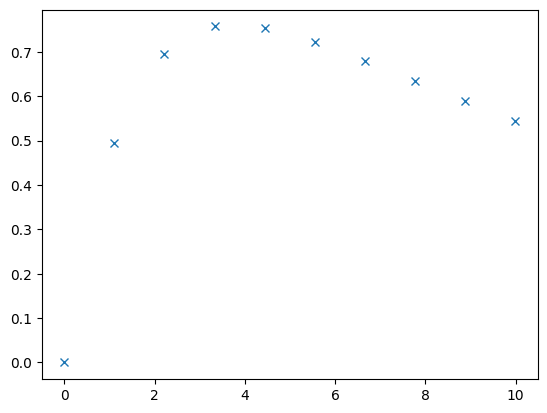

In [77]:
plt.plot(times[training_times], no_noise_data[training_times], marker="x", linewidth=0)

neural network - 1 hidden layer, 10 neurons

In [78]:
class VectorField(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2 = jr.split(key, 2)
        self.layers = [
            eqx.nn.Linear(2, 10, use_bias=True, key=key1),
            jnp.tanh,
            eqx.nn.Linear(10, 1, use_bias=True, key=key2)
        ]

    def __call__(self, t, y, args):
        t = jnp.asarray(t)[None]
        y = jnp.concatenate([t, y])
        for layer in self.layers:
            y = layer(y)
        return y

Neural ODE

In [82]:
class NeuralODE(eqx.Module):
    vector_field: VectorField

    def __init__(self, key):
        self.vector_field = VectorField(key)

    def __call__(self):
        vf = dfx.ODETerm(self.vector_field)
        t0 = 0
        t1 = 9.99
        dt0 = 0.01
        train_times_idxs = jnp.linspace(0, 999, 10, dtype=jnp.int32)
        times = jnp.linspace(t0, t1, 1000)
        saveat = dfx.SaveAt(ts=times[train_times_idxs])
        y0 = jnp.array([0.0])
        solver = dfx.Midpoint()
        sol = dfx.diffeqsolve(
            terms = vf,
            solver = solver,
            t0 = t0,
            t1 = t1,
            dt0 = dt0,
            y0 = y0,
            saveat = saveat,
            max_steps=999,
        )
        ts = sol.ts
        ys = sol.ys
        return ts, ys[:, -1]

RNG

In [83]:
SEED = 1
key = jr.key(SEED)
model_key, perm_key = jr.split(key, 2)

training

In [84]:
@eqx.filter_value_and_grad
def grad_loss(model, ys_data):
    ts, ys = model()
    return jnp.mean((ys_data - ys) ** 2)


@eqx.filter_jit
def make_step(model, ys_data, optim, opt_state):
    loss, grads = grad_loss(model, ys_data)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

neural_ode = NeuralODE(key)
optim = optax.adam(1e-2)
opt_state = optim.init(eqx.filter(neural_ode, eqx.is_inexact_array))

steps = 1000
perms = jr.randint(perm_key, shape=(steps,), minval=0, maxval=9)
for step in range(steps):
    ys_data = (train_data[perms[step], :])[training_times]
    # ys_data = no_noise_data
    loss, neural_ode, opt_state = make_step(neural_ode, ys_data, optim, opt_state)
    if step % 100 == 0 or step == steps - 1:
        print(f"Step: {step}, Loss: {loss}")

Step: 0, Loss: 0.6775131225585938
Step: 100, Loss: 0.009000346064567566
Step: 200, Loss: 0.004261346068233252
Step: 300, Loss: 0.0028413929976522923
Step: 400, Loss: 0.00127074692863971
Step: 500, Loss: 0.0016646443400532007
Step: 600, Loss: 0.0008453172631561756
Step: 700, Loss: 0.001380064175464213
Step: 800, Loss: 0.001730876392684877
Step: 900, Loss: 0.0012576162116602063
Step: 999, Loss: 0.0008837383356876671


In [85]:
ts, ys = neural_ode()

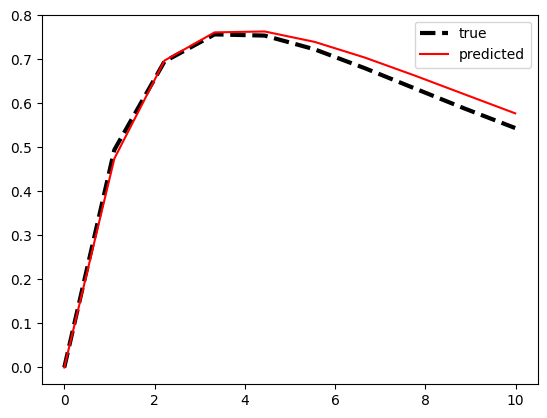

In [86]:
plt.plot(ts, no_noise_data[training_times], linestyle="--", color="black", linewidth=3, label="true")
plt.plot(ts, ys, color="red", label="predicted")
plt.legend()
plt.show()